![oi_masterdados](img/oi_masterdados2.png)

# Job Change of Data Scientists

## Este projeto tem o propósito de predizer quem irá para um novo emprego. Para isso, utilizaremos um modelo de classificação supervisionado.

# GRUPO 02

## ●  Iura Teixeira Xavier
## ●  Adames Oliveira
## ●  Fabyo Sousa Ramos

# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining


### CRISP-DM is a data mining methodology in cyclic format, which guide the discovery of knowledge for decision making on large volume data.

![Crisp 1](img/crisp1.jpg)

# DATASET

https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

## Job Change of Data Scientists

Context and Content
A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

This dataset designed to understand the factors that lead a person to leave current job for HR researches too. By model(s) that uses the current credentials,demographics,experience data you will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

The whole data divided to train and test . Target isn't included in test but the test target values data file is in hands for related tasks. A sample submission correspond to enrollee_id of test set provided too with columns : enrollee _id , target

### ●  The dataset is imbalanced.
### ●  Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
### ●  Missing imputation can be a part of your pipeline as well.

## Features

### ●  enrollee_id : Unique ID for candidate

### ●  city: City code

### ●  city_ development _index : Developement index of the city (scaled)

### ●  gender: Gender of candidate

### ●  relevent_experience: Relevant experience of candidate

### ●  enrolled_university: Type of University course enrolled if any

### ●  education_level: Education level of candidate

### ●  major_discipline :Education major discipline of candidate

### ●  experience: Candidate total ### - experience in years

### ●  company_size: No of employees in current employer's company

### ●  company_type : Type of current employer

### ●  lastnewjob: Difference in years between previous job and current job

### ●  training_hours: training hours completed

### ●  target: 0 – Not looking for job change, 1 – Looking for a job change

## Objetivos

### Predict the probability of a candidate will work for the company. Para isso temos que ter o menor número de Falso Positivo possível.
### Interpret model(s) such a way that illustrate which features affect candidate decision

# 0.0 IMPORTS

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pickle
import imblearn
import keras
import random
import itertools
import collections
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from IPython.display         import Image
from IPython.core.display    import HTML
from scipy                   import stats as ss
from datetime                import timedelta
from boruta                  import BorutaPy
from scipy.stats import ks_2samp
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.naive_bayes     import GaussianNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from keras.models            import Sequential
from keras.layers            import Dense
from keras.wrappers.scikit_learn  import KerasClassifier
from xgboost                 import XGBClassifier, XGBRFClassifier
from imblearn.over_sampling  import SMOTE
from imblearn.combine        import SMOTETomek
from pandas_profiling        import ProfileReport

warnings.filterwarnings('ignore')

# 1.0 HELPER FUNCTIONS

In [2]:
def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

def check_nan(df):
    '''
    Takes df
    Checks nulls
    '''
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0]
        
        missing_data = pd.concat([total, percent*100], axis=1, keys=['Total Missing', 'Percent'])
  
        print('● Dataset contains NaN values.\n')
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('● Dataset does not contains NaN values. No NaN found.')
        
    return nan_cols


def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g


def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )


def plot_roc_curve(fpr, tpr, auc):
    plt.plot(fpr, tpr)
    plt.title('ROC Curve - AUC: {}'.format(auc))
    plt.xlabel('1 - Especificidade (FPR)')
    plt.ylabel('Sensibilidade (TPR)')
    plt.grid(True)
    plt.show()


def udf_cross_validation(X_train, y_train, classifier_name, classifier, num_folds, n_repeats, verbose=False):
    inicio            = time.time()
    i                 = 1
    accuracy_list     = []
    balanced_acc_list = []
    kappa_acc_list    = []
    conf_matrix       = []
    mcc_list          = []
    auc_list          = []
    fpr_list          = []
    tpr_list          = []
    thresholds_list   = []        
    rskf              = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=n_repeats, random_state=36851234)
    
    # generate k-fold
    for train_idx, val_idx in rskf.split( X_train, y_train ):
        if verbose:
            print( '\n****** Running {}/{} ******'.format(i, n_repeats*num_folds) )
            
        # get training fold
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx].values.ravel()
        
        # get validation fold
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # training model
        classifier.fit(X_train_fold, y_train_fold)

        # predicting
        y_pred  = classifier.predict(X_val_fold)
        y_proba = classifier.predict_proba(X_val_fold)
        
        # metrics
        ## accuracy_score - Total of corrects predictions, main diagonal of the confusion matrix DIVIDED by the total of predictions
        score = accuracy_score(y_val_fold, y_pred)
        accuracy_list.append(score)
        
        ## Balanced Accuracy - Very goog to multi class analyses. Get all classes accuracy and extract the average. 
        balanced_acc = balanced_accuracy_score(y_val_fold, y_pred)
        balanced_acc_list.append(balanced_acc)
        
        ## Kappa score
        kappa_acc = cohen_kappa_score( y_val_fold, y_pred )
        kappa_acc_list.append(kappa_acc)
        
        # matthews_corrcoef - First, It is a metric that takes into account all the possibilities of a binary classification problem (TP, TN, FP and FN).
        #                            It is robust to unbalanced datasets. The result of it is a normalized coefficient between -1 and 1 that is easy to interpret.
        #
        #                            -1 : the closer your MCC is to -1, the worse your classifier is. In other words, he is making more mistakes than he gets right.
        #                            +1 : on the other hand, the closer to +1, the better your classifier. That is, he is hitting more than he misses.
        #                             0 : when the coefficient is close to 0, it shows that the classifier is just "kicking" the most frequent class (es).
        
        mcc = matthews_corrcoef( y_val_fold, y_pred )
        mcc_list.append( mcc )
        
        ## roc curve
        y_proba = y_proba[:, 1]
        auc = roc_auc_score(y_val_fold, y_proba)
        fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba)
        auc_list.append(auc)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds_list.append(thresholds)
        
        conf_matrix.append( confusion_matrix(y_val_fold, y_pred) ) 
        i+=1
        
    # metrics ------------------------------------------------------------------------------------------------------
    
    # confusion matrix
    cnf_matrix = np.mean(conf_matrix, axis=0)
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    # Precision, mede a proporção de predições positivas que estão corretas, ou seja, quão bem o modelo predisse os valores positivos.
    precision = TP / ( TP + FP ) 
    
    # Recall, True Positive Rate (TPR) ou Sensitividade. Mede uma proporção dos valores que são de fato positivos e que foram preditos corretamente.Recall is quite important when you want to minimise the case of FN.
    recall = TP / ( TP + FN )
    
    # F1 Score
    F1 = 2 * (precision * recall) / (precision + recall)
    
    # Specificity - How good the algorithm is at hitting the negative class. In other words: "Of the negative samples, how many did the algorithm get right?
    specificity = TN / ( TN+FP )

    # NPV - Negative Predictive Value - How much you trust the negative class prediction. In other words: “Of the samples that my algorithm said were negative, how many really are?
    npv = TN / (TN + FN)
    
    # plot confusion matrix
    udf_plot_confusion_matrix(cnf_matrix, [0, 1], normalize=False)
    
    # plot roc curve
    plot_roc_curve(fpr, tpr, np.round( np.mean(auc_list), 2 ).astype(str))

    #print( 'Confusion matrix:\n{}\n'.format( cnf_matrix ) )
    
    fim = time.time()
    
    df_classifier_result = pd.DataFrame(
        {
            'Classifier Name'                  : classifier_name,
            'Tempo de execução (s):'               : fim-inicio,
            'Accuracy score'                   : np.round( np.mean(accuracy_list), 2 ).astype(str),
            'Precision score'                  : np.round( precision, 2 ).astype(str),
            'Recall score'                     : np.round( recall, 2 ).astype(str),
            'F1 score'                         : np.round( F1, 2 ).astype(str),
            'Specificity'                      : np.round( specificity, 2 ).astype(str),
            'NPV'                              : np.round( npv, 2 ).astype(str),
            'Balanced Accuracy score'          : np.round( np.mean(balanced_acc_list), 2 ).astype(str),
            'AUC'                              : np.round( np.mean(auc_list), 2 ).astype(str),
            'Kappa score'                      : np.round( np.mean(kappa_acc_list), 2 ).astype(str),
            'Matthews Correlation Coefficient' : np.round( np.mean(mcc_list), 2 ).astype(str)
        },
        index=[0]
    )
        
    return df_classifier_result


def udf_plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.0f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.0f}; misclass={:0.0f}'.format(accuracy, misclass))
    plt.show()


def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 2.0 DATA LOADING

In [3]:
# load data
df0 = pd.read_csv('aug_train.csv')
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [4]:
df0.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# 3.0 DATA PREPROCESSING

In [5]:
df1 = df0.copy()

## 3.1 Data Dimensions

In [6]:
df_shape = df1.shape
print('● Dataset contains {} rows and {} columns.'.format(df_shape[0], df_shape[1]))

● Dataset contains 19158 rows and 14 columns.


## 3.2 Detecting Missing Values

In [7]:
# check "not available" values
#df1.isna().sum()

nan_cols = check_nan(df1)

● Dataset contains NaN values.

Total and Percentage of NaN:
                      Total Missing    Percent
company_type                  6140  32.049274
company_size                  5938  30.994885
gender                        4508  23.530640
major_discipline              2813  14.683161
education_level                460   2.401086
last_new_job                   423   2.207955
enrolled_university            386   2.014824
experience                      65   0.339284


## 3.3 Missing Values Distributions

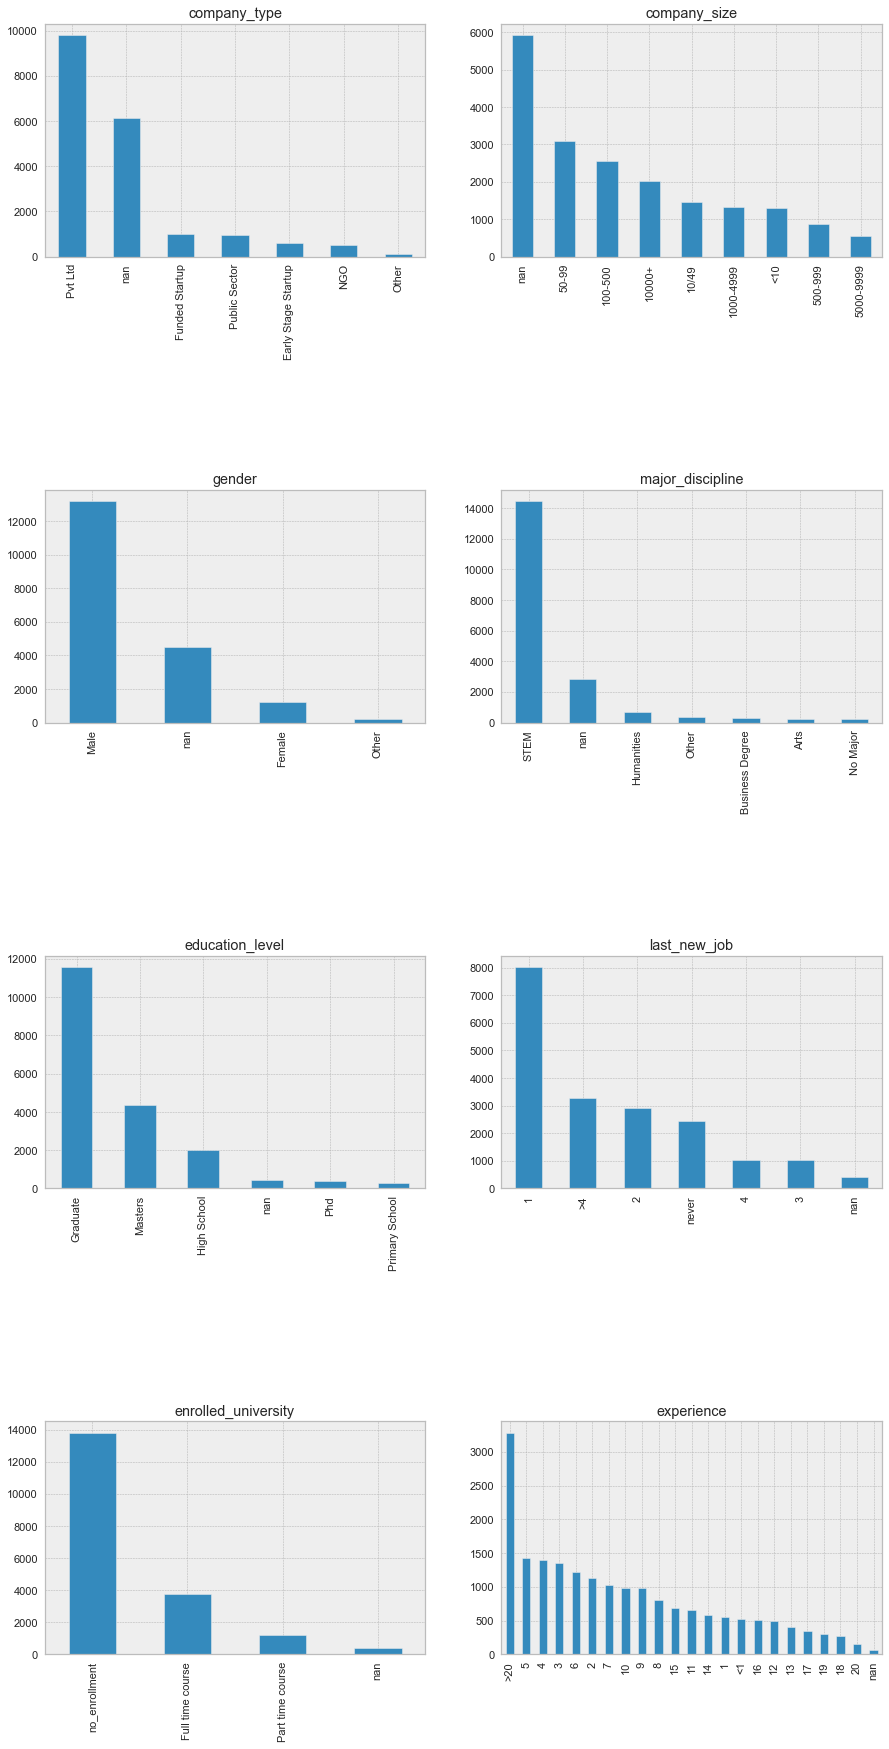

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15,30))
plt.subplots_adjust(hspace=1) #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

# using value_counts(dropna=False) to show missing values
nan_cols

df1['company_type'].value_counts(dropna=False).plot(kind="bar", title='company_type', ax=axes[0,0]);
df1['company_size'].value_counts(dropna=False).plot(kind="bar", title='company_size', ax=axes[0,1]);
df1['gender'].value_counts(dropna=False).plot(kind="bar", title='gender', ax=axes[1,0]);
df1['major_discipline'].value_counts(dropna=False).plot(kind="bar", title='major_discipline', ax=axes[1,1]);
df1['education_level'].value_counts(dropna=False).plot(kind="bar", title='education_level', ax=axes[2,0]);
df1['last_new_job'].value_counts(dropna=False).plot(kind="bar", title='last_new_job', ax=axes[2,1]);
df1['enrolled_university'].value_counts(dropna=False).plot(kind="bar", title='enrolled_university', ax=axes[3,0]);
df1['experience'].value_counts(dropna=False).plot(kind="bar", title='experience', ax=axes[3,1]);


## 3.4 Fillout Missing Values

### How to treat missing values ? Why ?

In [9]:
# company_type
df1['company_type'].fillna('Unknown', inplace = True)

# company_size
df1['company_size'].fillna('Unknown', inplace = True)

# gender, replace the missing value by the most frequent value
df1['gender'].fillna(df1['gender'].mode()[0], inplace = True)

# major_discipline, replace the missing value by the most frequent value
df1['major_discipline'].fillna(df1['major_discipline'].mode()[0], inplace = True)

# education_level, replace the missing value by the most frequent value
df1['education_level'].fillna(df1['education_level'].mode()[0], inplace = True)

# last_new_job, replace the missing value by the most frequent value
df1['last_new_job'].fillna(df1['last_new_job'].mode()[0], inplace = True)

# enrolled_university, replace the missing value by the most frequent value
df1['enrolled_university'].fillna(df1['enrolled_university'].mode()[0], inplace = True)

# experience, replace the missing value by the most frequent value
df1['experience'].fillna(df1['experience'].mode()[0], inplace = True)

In [10]:
check_nan(df1)

● Dataset does not contains NaN values. No NaN found.


[]

# 4.0 FEATURE ENGINEERING

In [11]:
df2 = df1.copy()

## 4.1 Mapa Mental de Hipóteses

![feature_engineering](img/mind_map.png)

## 4.2 - Criando hipóteses para geração de insights

**1.** Candidatos de cidades desenvolvidas mudam mais de emprego ?

**2.** Empresas localizadas no centro possuem mais influência na mudança de emprego ?

**3.** O Home-office é um fator forte para mudança de emprego ?

**4.** Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

**5.** Candidatos com mais tempo de estudo mudam mais de emprego ?

**6.** Candidatos de empresas pequenas mudam mais de emprego ?

**7.** O final do ano é um indicador de maior mudança de emprego ?

**7.** Candidatos com mais experiências mudam mais de emprego ?

**9.** Candidatos com filhos mudam menos de emprego ?

**10.** Candidatos do sexo masculino mudam mais de emprego ?

### 4.2.4 - Lista final de hipóteses.

**1.** Candidatos de cidades desenvolvidas mudam mais de emprego ?

**2.** Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

**3.** Candidatos com mais tempo de estudo mudam mais de emprego ?

**4.** Candidatos de empresas pequenas mudam mais de emprego ?

**5.** Candidatos com mais experiências mudam mais de emprego ?

**6.** Candidatos do sexo masculino mudam mais de emprego ?

## 4.3 Variáveis Categóricas e Numéricas

In [12]:
# create dataframe by data type
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

print( 'Variáveis numéricas:\n\n{}\n'.format(num_attributes.columns) )
print( 'Variáveis categóricas:\n\n{}\n'.format(cat_attributes.columns) )

Variáveis numéricas:

Index(['enrollee_id', 'city_development_index', 'training_hours', 'target'], dtype='object')

Variáveis categóricas:

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')



## 4.3 Feature Engineering - Variáveis Numéricas

In [13]:
#cria classes , baseado nos quartis
df2['fe_cdi'] = df2['city_development_index'].apply( lambda x: 1 if x<=0.740000 else 2 if x<=0.903000 else 3 if x<=0.920000 else 4)
df2['fe_training_hours'] = df2['training_hours'].apply( lambda x: 1 if x<=23.000000 else 2 if x<=47.000000 else 3 if x<=88.000000 else 4)

df2[['city_development_index', 'fe_cdi', 'training_hours', 'fe_training_hours']].head()

,city_development_index,fe_cdi,training_hours,fe_training_hours
0,0.920,3,36,2
1,0.776,2,47,2
2,0.624,1,83,3
3,0.789,2,52,3
4,0.767,2,8,1


## 4.4 Feature Engineering - Variáveis Categóricas

In [14]:
print('\n● Distribuição de categorias nas variáveis preditoras. \n')
for col in cat_attributes:
    svalues = df2[col].value_counts()
    print( '\n● {}\n'.format(col) )
    icont = 0
    for i, sval in enumerate(svalues): 
        print('● {} Qtde: {} Perc.: {}'.format( svalues.index[i], sval, sval / svalues.sum() ) )
        icont +=1
    print( '\nA variável {} possue {} categorias\n'.format(col, icont) )


● Distribuição de categorias nas variáveis preditoras. 


● city

● city_103 Qtde: 4355 Perc.: 0.22732017955945297
● city_21 Qtde: 2702 Perc.: 0.14103768660611754
● city_16 Qtde: 1533 Perc.: 0.08001879110554337
● city_114 Qtde: 1336 Perc.: 0.06973588057208477
● city_160 Qtde: 845 Perc.: 0.04410690051153565
● city_136 Qtde: 586 Perc.: 0.030587744023384485
● city_67 Qtde: 431 Perc.: 0.022497129136653096
● city_75 Qtde: 305 Perc.: 0.015920242196471448
● city_102 Qtde: 304 Perc.: 0.015868044681073182
● city_104 Qtde: 301 Perc.: 0.01571145213487838
● city_73 Qtde: 280 Perc.: 0.014615304311514771
● city_100 Qtde: 275 Perc.: 0.014354316734523438
● city_71 Qtde: 266 Perc.: 0.013884539095939034
● city_11 Qtde: 247 Perc.: 0.01289278630337196
● city_61 Qtde: 197 Perc.: 0.010282910533458608
● city_90 Qtde: 197 Perc.: 0.010282910533458608
● city_28 Qtde: 192 Perc.: 0.010021922956467273
● city_23 Qtde: 182 Perc.: 0.009499947802484601
● city_65 Qtde: 175 Perc.: 0.009134565194696732
● city_36 Qtde: 1

### ● Criação de classes categóricas.

### ● Devemos trabalhar as variáveis categóricas com a técnica de Optimal Binning. Isso vai garantir um melhor information value.

In [15]:
df2['fe_enrolled_university'] = np.where( df2['enrolled_university'] ==  'no_enrollment', 0, 1)
df2['fe_education_level']     = df2['education_level'].apply( lambda x: 1 if x in ('High School', 'Primary School') else 2 if x == 'Graduate' else 3 )
df2['fe_major_discipline']    = np.where( df2['major_discipline'] == 'STEM', 'STEM', 'Other')
df2['fe_experience']          = df2['experience'].apply( lambda x: 1 if x in ('<', '1', '2' '3', '4', '5') else 2 if x in ('6', '7', '8', '9', '10') else 3 if x in ('11', '12', '13', '14', '15', '16', '17', '18', '19') else 4 )
df2['fe_company_size']        = df2['company_size'].apply( lambda x: 1 if x in ('<10', '10-49', '50-99') else 2 if x in ('100-500', '500-999') else 3 )
df2['fe_company_type']        = df2['company_type'].apply( lambda x: x if x in ('Pvt Ltd', 'Unknown') else 'Other' )
df2['fe_last_new_job']        = df2['last_new_job'].apply( lambda x: 0 if x == 'never' else 1 if x == '1' else 2 if x in ('2', '3') else 3  )
df2.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_major_discipline,fe_experience,fe_company_size,fe_company_type,fe_last_new_job
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,Unknown,Unknown,1,36,1.0,3,2,0,2,STEM,4,3,Unknown,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,2,2,0,2,STEM,3,1,Pvt Ltd,3
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,Unknown,Unknown,never,83,0.0,1,3,1,2,STEM,1,3,Unknown,0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,Unknown,Pvt Ltd,never,52,1.0,2,3,0,2,Other,4,3,Pvt Ltd,0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,2,1,0,3,STEM,4,1,Other,3


# 5.0 EXPLORATORY DATA ANALYSIS

## 5.1 Numerical Attributes Statistics

In [17]:
df2.describe()

,enrollee_id,city_development_index,training_hours,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job
count,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348,2.378954,2.489978,0.258639,2.127884,2.724763,2.361624,1.527717
std,9616.292592,0.123362,60.058462,0.432647,1.002653,1.123839,0.437898,0.595203,1.109679,0.830233,0.977824
min,1.000000,0.448000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000
50%,16982.500000,0.903000,47.000000,0.000000,2.000000,2.000000,0.000000,2.000000,3.000000,3.000000,1.000000
75%,25169.750000,0.920000,88.000000,0.000000,3.000000,3.000000,1.000000,2.000000,4.000000,3.000000,2.000000
max,33380.000000,0.949000,336.000000,1.000000,4.000000,4.000000,1.000000,3.000000,4.000000,3.000000,3.000000


### ● A Média da variável target informa que 25%( percentual de ocorrência do evento) mudaram de emprego.

## 5.2 Univariate Analysis

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

### 5.2.1 - Variáveis Numéricas

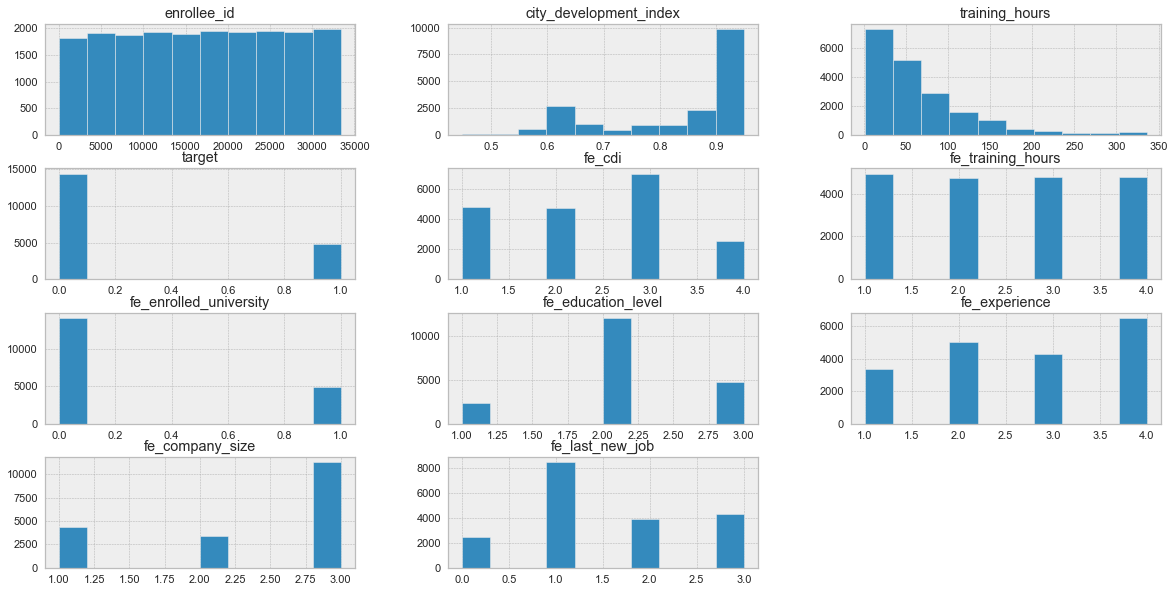

In [21]:
num_attributes = df2.select_dtypes( exclude=['object', 'datetime64[ns]', 'category'] )
num_attributes.hist();

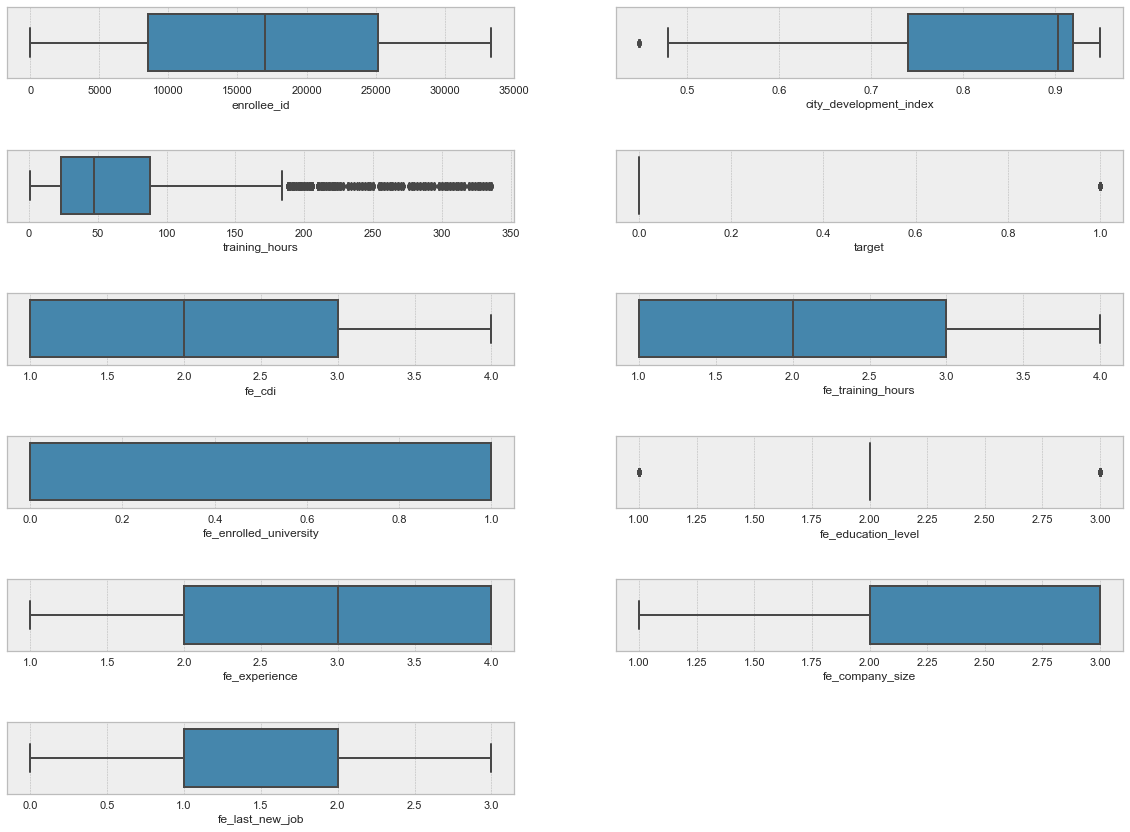

In [55]:
# mount grid 2 rows x 6 cols to receive charts
grid = GridSpec( nrows=10, ncols=2, hspace=1)
plt.figure(figsize=(20,25))

i = 0
iline = 1
ax_col = 1
ax_row = 0
for col in num_attributes.columns:
    #print(col)
    ax_col = int(not ax_col) # troca entre 0 e 1
    plt.subplot(grid[iline,ax_col])
    sns.boxplot( x=df2[col])
    if (i % 2 > 0):
        iline +=1
    i += 1

### ●  Nossas variáveis não possuem uma distribuição normal.

### ●  Temos outliers nas variáveis preditoras city_development_index e training_hours.

### 5.2.2 - Variáveis Categóricas

#### ● Nosso Dataset possui muitas variáveis categóricas (Nominais, Ordinais, Binárias), algumas com alta cardinalidade.

In [26]:
cat_attributes = df2.select_dtypes( include=['object', 'category'] )

print('● Variáveis categóricas e quantidades de categorias.\n')
for col in cat_attributes:
    print('● {}: {}'.format(col, len( df2[col].unique() ) ) )

● Variáveis categóricas e quantidades de categorias.

● city: 123
● gender: 3
● relevent_experience: 2
● enrolled_university: 3
● education_level: 5
● major_discipline: 6
● experience: 22
● company_size: 9
● company_type: 7
● last_new_job: 6
● fe_major_discipline: 2
● fe_company_type: 3


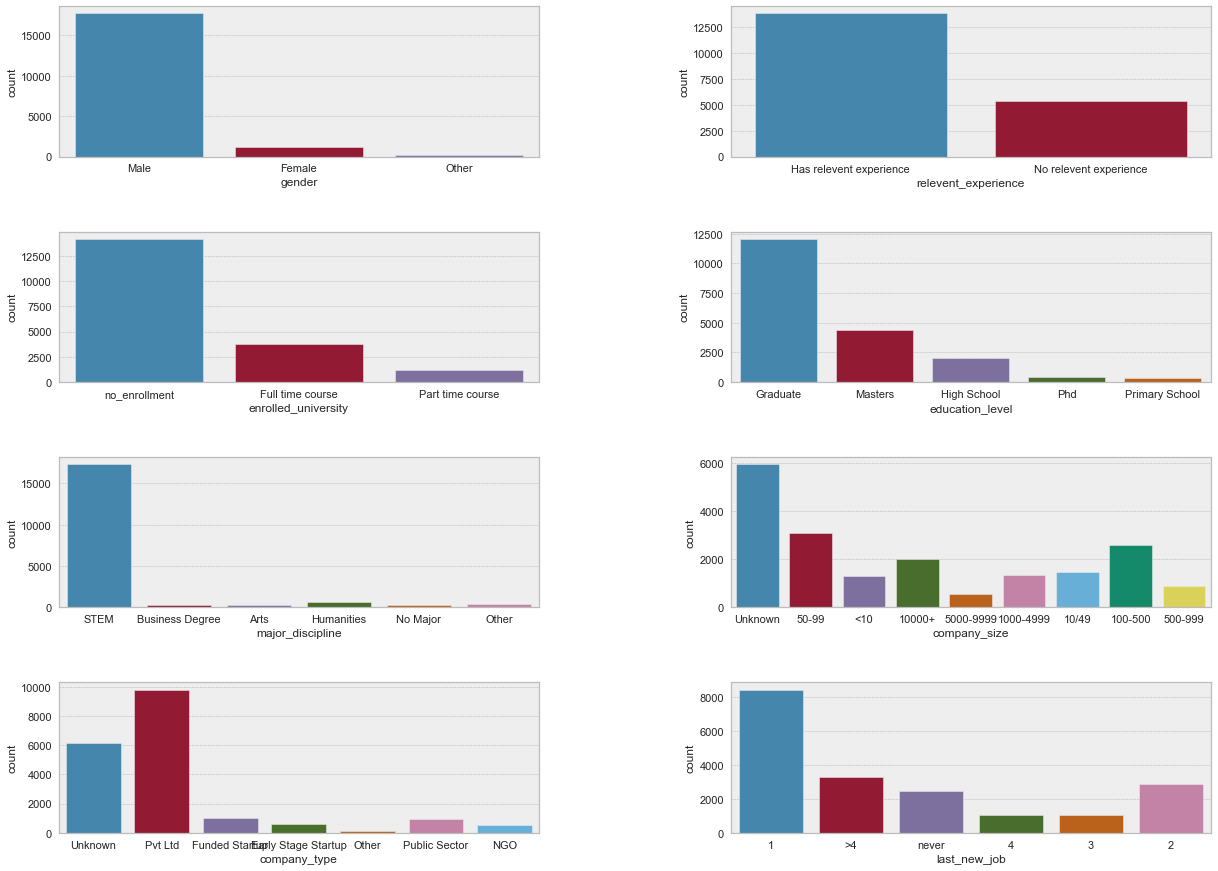

In [27]:
cat_list = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']
plt.figure(figsize=(20,30))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)
i = 0
ilines_plot = 8
for col in cat_list:
    i += 1
    plt.subplot(ilines_plot, 2, i)
    #i += 1
    sns.countplot(df2[col])
    #plt.subplot(ilines_plot, 2, i)
    #for categ in df1[col].unique():
    #    sns.kdeplot(df1[df1[col] == categ]['target'], label=categ, shade=True) 
    #plt.legend()

### 5.2.3 What about statistics above ?

### 5.2.2 Variável Resposta

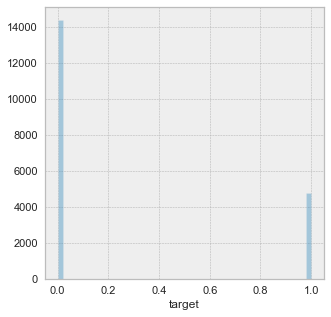

In [56]:
plt.rcParams['figure.figsize']=(5,5)
sns.distplot(df2['target'], kde=False);

#### ● We have an imbalanced dataset. We have to balanced the dataset, using undersamplig or oversampling techniques, to get a better model.

## 5.3 Bivariate Analysis

In [ ]:
df2.head()

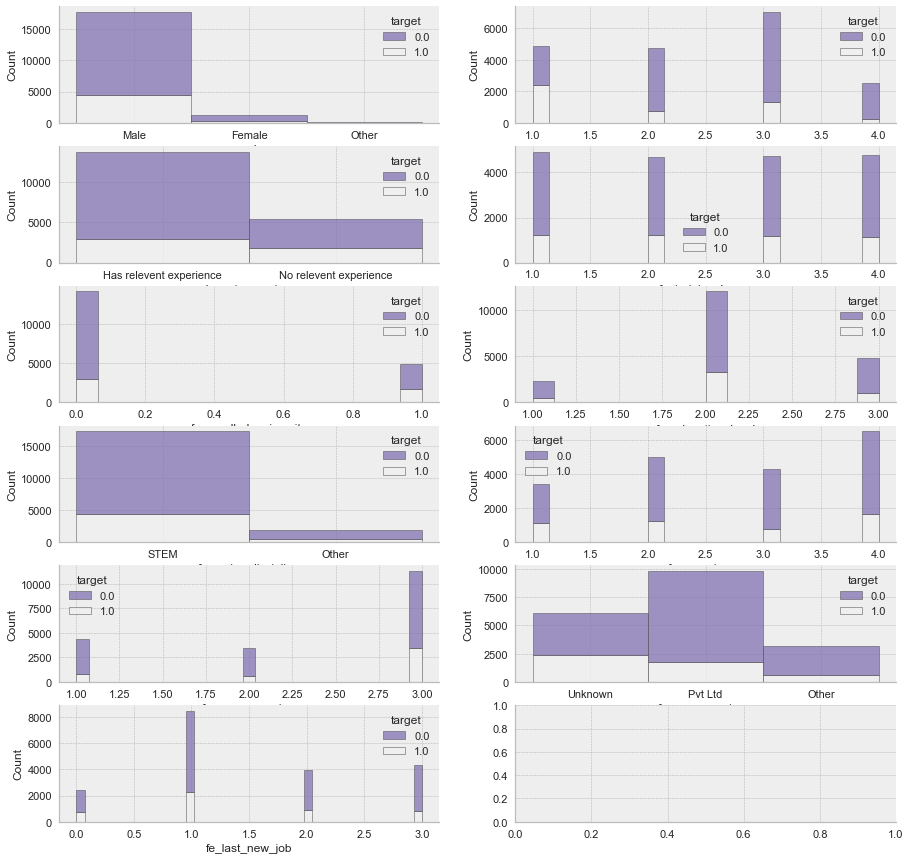

In [21]:
cat_list = ['gender', 'fe_cdi', 'relevent_experience', 'fe_training_hours', 'fe_enrolled_university', 'fe_education_level', 'fe_major_discipline', 'fe_experience', 'fe_company_size', 'fe_company_type', 'fe_last_new_job']

f, ax = plt.subplots( int( ceil( len(cat_list)/2 ) ), 2,figsize=(15, 15))

sns.despine(f)

i = 0
iline = 0
ax_col = 1
ax_row = 0
for col in cat_list:
    ax_col = int(not ax_col) # troca entre 0 e 1
    sns.histplot(
        df2,
        x=col,
        hue="target",
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        log_scale=False,
        ax=ax[iline,ax_col]
    );    
    if (i % 2 > 0):
        iline +=1
    i += 1

### H1. Candidatos de cidades desenvolvidas mudam mais de emprego ?

**Falso** Candidatos de cidades desenvolvidas mudam menos de emprego.

In [ ]:
aux = df2.loc[df2['target'] == 1, 'fe_cdi'].reset_index().groupby('fe_cdi').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_cdi', y = 'qtde', data = aux, ci = None);

### H2. Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

**Falso** Candidatos com nível de escolaridade mais alto mudam menos de emprego.

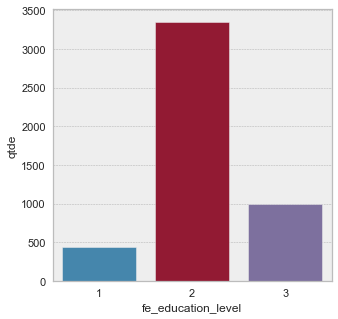

In [57]:
aux = df2.loc[df2['target'] == 1, 'fe_education_level'].reset_index().groupby('fe_education_level').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_education_level', y = 'qtde', data = aux, ci = None);

### H3. Candidatos com mais tempo de estudo mudam mais de emprego ?

**Falso** Candidatos com mais tempo de estudo mudam menos de emprego.

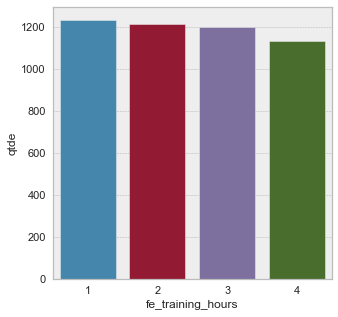

In [58]:
aux = df2.loc[df2['target'] == 1, 'fe_training_hours'].reset_index().groupby('fe_training_hours').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_training_hours', y = 'qtde', data = aux, ci = None);

### H4. Candidatos de empresas pequenas mudam mais de emprego ?

**Falso** Candidatos de empresas maiores mudam mais de emprego.

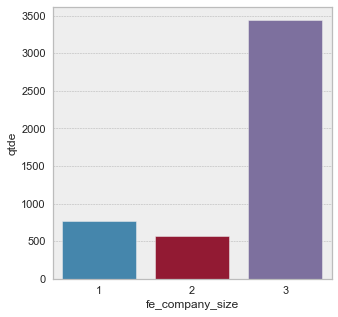

In [59]:
aux = df2.loc[df2['target'] == 1, 'fe_company_size'].reset_index().groupby('fe_company_size').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_company_size', y = 'qtde', data = aux, ci = None);

### H5. Candidatos com mais experiências mudam mais de emprego ?

**Verdadeiro** Candidatos com mais experiências mudam mais de emprego.

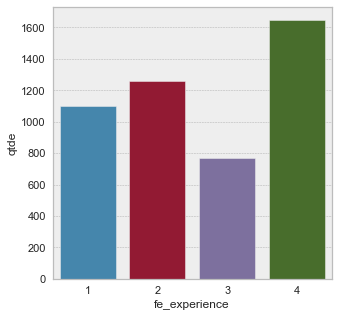

In [60]:
aux = df2.loc[df2['target'] == 1, 'fe_experience'].reset_index().groupby('fe_experience').size().to_frame('qtde').reset_index()
sns.barplot(x = 'fe_experience', y = 'qtde', data = aux, ci = None);

### H5. Candidatos do sexo masculino mudam mais de emprego ?

**Verdadeiro** Candidatos do sexo masculino mudam mais de emprego.

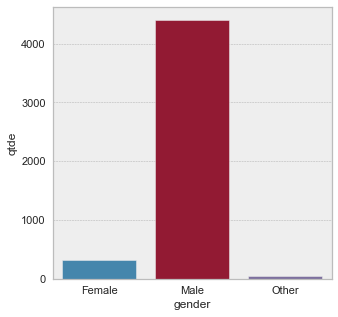

In [61]:
aux = df2.loc[df2['target'] == 1, 'gender'].reset_index().groupby('gender').size().to_frame('qtde').reset_index()
sns.barplot(x = 'gender', y = 'qtde', data = aux, ci = None);

### Resumo das Hipóteses

H1. **FALSO** Candidatos de cidades desenvolvidas mudam mais de emprego ?

H2. **FALSO** Candidatos com nível de escolaridade mais alto mudam mais de emprego ?

H3. **FALSO** Candidatos com mais tempo de estudo mudam mais de emprego ?

H4. **FALSO** Candidatos de empresas pequenas mudam mais de emprego ?

H5. **VERDADEIRO** Candidatos com mais experiências mudam mais de emprego ?

H6. **VERDADEIRO** Candidatos do sexo masculino mudam mais de emprego ?

## 5.5 Multivariate Analysis

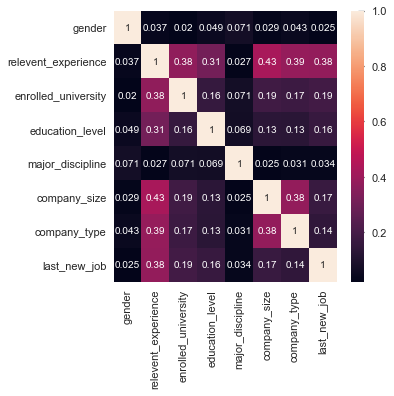

In [62]:
a = df2[cat_list]

i = 0
for v1 in a.columns:
    i +=1
    list_cramerv = []
    for v2 in a.columns:
        cramer_v_result = cramer_v(a[v1], a[v2])
        list_cramerv.append(cramer_v_result)
    df_cramerv_2 = pd.DataFrame({v1: list_cramerv})
    if i==1:
        df_cramerv = df_cramerv_2.copy()
    else:
        df_cramerv = pd.concat([df_cramerv, df_cramerv_2], axis=1)
        
df_cramerv = df_cramerv.set_index(df_cramerv.columns)
sns.heatmap(df_cramerv, annot=True);

## 4.5 Odds Ratio

### Odds Ratio - Gender

In [156]:
log_reg_gender = smf.logit("target ~ C( gender, Treatment('Male'))", data=df1).fit()
log_reg_gender.summary()

Optimization terminated successfully.
         Current function value: 0.561577
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19155
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:               7.203e-05
Time:                        12:59:05   Log-Likelihood:                -10759.
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                    0.4607
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -1.1080      0.017    -63.734      0.000      -1.142      -1.074
C(gender, Treatment('Male'))[T.Female]     0.0793      0.067      1.186      0.235      -0.052       0.210
C(gender, Treatment('Male'))[T.Other]      0.0713      0.166      0.431      0.667      -0.253       0.396
==========================================================================================================
"""

In [157]:
# ODDS RATIO
odds_ratio = pd.DataFrame({
    'OR': log_reg_gender.params,
    'Lower CI': log_reg_gender.conf_int()[0],
    'Upper CI': log_reg_gender.conf_int()[1]
})

odds_ratio = np.exp(odds_ratio)
odds_ratio

,OR,Lower CI,Upper CI
Intercept,0.330207,0.319145,0.341653
"C(gender, Treatment('Male'))[T.Female]",1.082521,0.949622,1.234020
"C(gender, Treatment('Male'))[T.Other]",1.073902,0.776390,1.485420


#### Gender, P-Value alto, não significativo. Odds Ratio próximo de 1, o Gender não interfere na probabilidade de mudança de emprego.

### Odds Ratio - relevent_experience

In [158]:
log_reg = smf.logit("target ~ C( relevent_experience, Treatment('Has relevent experience'))", data=df1).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.553682
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19156
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Jul 2022   Pseudo R-squ.:                 0.01413
Time:                        12:59:05   Log-Likelihood:                -10607.
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                 4.357e-68
==========================================================================================================================================================
                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 -1.2969      0.021    -62.538      0.000      -1.338      -1.256
C(relevent_experience, Treatment('Has relevent experience'))[T.No relevent experience]     0.6266      0.036     17.635      0.000       0.557       0.696
==========================================================================================================================================================
"""

In [159]:
# ODDS RATIO
odds_ratio = pd.DataFrame({
    'OR': log_reg.params,
    'Lower CI': log_reg.conf_int()[0],
    'Upper CI': log_reg.conf_int()[1]
})

odds_ratio = np.exp(odds_ratio)
odds_ratio

,OR,Lower CI,Upper CI
Intercept,0.273382,0.262493,0.284723
"C(relevent_experience, Treatment('Has relevent experience'))[T.No relevent experience]",1.871189,1.745316,2.006139


#### Pessoas sem experiência possuem 87% mais chance de mudar de emprego.

### Odds Ratio - enrolled_university

In [23]:
log_reg = smf.logit("target ~ C( enrolled_university, Treatment('no_enrollment'))", data=df1).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.550849
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                19158
Model:                          Logit   Df Residuals:                    19155
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Jun 2022   Pseudo R-squ.:                 0.01917
Time:                        20:20:36   Log-Likelihood:                -10553.
converged:                       True   LL-Null:                       -10759.
Covariance Type:            nonrobust   LLR p-value:                 2.561e-90
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -1.2991      0.020    -63.530      0.000      -1.339      -1.259
C(enrolled_university, Treatment('no_enrollment'))[T.Full time course]     0.8133      0.039     20.679      0.000       0.736       0.890
C(enrolled_university, Treatment('no_enrollment'))[T.Part time course]     0.2116      0.070      3.039      0.002       0.075       0.348
==========================================================================================================================================
"""

In [24]:
# ODDS RATIO
odds_ratio = pd.DataFrame({
    'OR': log_reg.params,
    'Lower CI': log_reg.conf_int()[0],
    'Upper CI': log_reg.conf_int()[1]
})

odds_ratio = np.exp(odds_ratio)
odds_ratio

,OR,Lower CI,Upper CI
Intercept,0.272784,0.262068,0.283939
"C(enrolled_university, Treatment('no_enrollment'))[T.Full time course]",2.255332,2.088010,2.436063
"C(enrolled_university, Treatment('no_enrollment'))[T.Part time course]",1.235605,1.078023,1.416221


#### Pessoas com Full time course possuem 2,25 mais chances de mudarem de emprego.

### KS - Kolmogorov–Smirnov

In [25]:
print( 'city: ', ks_2samp( df1.loc[df1.target==0, "city"], df1.loc[df1.target==1, "city"] ), '\n' )
print( 'city_development_index: ', ks_2samp( df1.loc[df1.target==0, "city_development_index"], df1.loc[df1.target==1, "city_development_index"] ), '\n' )
print( 'gender: ', ks_2samp( df1.loc[df1.target==0, "gender"], df1.loc[df1.target==1, "gender"] ), '\n' )
print( 'relevent_experience: ', ks_2samp( df1.loc[df1.target==0, "relevent_experience"], df1.loc[df1.target==1, "relevent_experience"] ), '\n' )
print( 'enrolled_university: ', ks_2samp( df1.loc[df1.target==0, "enrolled_university"], df1.loc[df1.target==1, "enrolled_university"] ), '\n' )
print( 'education_level: ', ks_2samp( df1.loc[df1.target==0, "education_level"], df1.loc[df1.target==1, "education_level"] ), '\n' )
print( 'enrolled_university: ', ks_2samp( df1.loc[df1.target==0, "enrolled_university"], df1.loc[df1.target==1, "enrolled_university"] ), '\n' )
print( 'major_discipline: ', ks_2samp( df1.loc[df1.target==0, "major_discipline"], df1.loc[df1.target==1, "major_discipline"] ), '\n' )
print( 'experience: ', ks_2samp( df1.loc[df1.target==0, "experience"], df1.loc[df1.target==1, "experience"] ), '\n' )
print( 'company_size: ', ks_2samp( df1.loc[df1.target==0, "company_size"], df1.loc[df1.target==1, "company_size"] ), '\n' )
print( 'company_type: ', ks_2samp( df1.loc[df1.target==0, "company_type"], df1.loc[df1.target==1, "company_type"] ), '\n' )
print( 'last_new_job: ', ks_2samp( df1.loc[df1.target==0, "last_new_job"], df1.loc[df1.target==1, "last_new_job"] ), '\n' )
print( 'training_hours: ', ks_2samp( df1.loc[df1.target==0, "training_hours"], df1.loc[df1.target==1, "training_hours"] ), '\n' )

city:  KstestResult(statistic=0.17375126744887925, pvalue=3.81851123060983e-95) 

city_development_index:  KstestResult(statistic=0.33678883721233543, pvalue=0.0) 

gender:  KstestResult(statistic=0.004826659020839272, pvalue=0.9999956388378708) 

relevent_experience:  KstestResult(statistic=0.13330142169855597, pvalue=4.989163476335782e-56) 

enrolled_university:  KstestResult(statistic=0.13873437169682154, pvalue=1.1344859258886599e-60) 

education_level:  KstestResult(statistic=0.09547690569382639, pvalue=6.662293245518672e-29) 

enrolled_university:  KstestResult(statistic=0.13873437169682154, pvalue=1.1344859258886599e-60) 

major_discipline:  KstestResult(statistic=0.008934956904227118, pvalue=0.9345341890658645) 

experience:  KstestResult(statistic=0.08632879859434706, pvalue=1.0606475383585466e-23) 

company_size:  KstestResult(statistic=0.2591770416962569, pvalue=5.892225915048739e-213) 

company_type:  KstestResult(statistic=0.2378800430644037, pvalue=5.029332294116678e-179)

In [26]:
KS acima de 30%, bom KS.
city_development_index 


SyntaxError: invalid syntax (<ipython-input-26-04792eb55c88>, line 1)

# 6.0 DATA TRANSFORMATION



In [23]:
df3 = df2.copy()
df3.drop(['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours'], axis='columns', inplace=True)
df3.head()

,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_major_discipline,fe_experience,fe_company_size,fe_company_type,fe_last_new_job
0,1.0,3,2,0,2,STEM,4,3,Unknown,1
1,0.0,2,2,0,2,STEM,3,1,Pvt Ltd,3
2,0.0,1,3,1,2,STEM,1,3,Unknown,0
3,1.0,2,3,0,2,Other,4,3,Pvt Ltd,0
4,0.0,2,1,0,3,STEM,4,1,Other,3


### ● Neste primeiro ciclo não faremos a normalização dos dados, até por que estão na mesma escala.

## 6.1 Transformation

### 6.1.1 Encoding

### ● Vamos transformar algumas varíaveis categóricas utilizando o one hot encoding.

In [24]:
df3 = pd.get_dummies(df3, columns=['fe_major_discipline', 'fe_company_type'])
df3.head()

,target,fe_cdi,fe_training_hours,fe_enrolled_university,fe_education_level,fe_experience,fe_company_size,fe_last_new_job,fe_major_discipline_Other,fe_major_discipline_STEM,fe_company_type_Other,fe_company_type_Pvt Ltd,fe_company_type_Unknown
0,1.0,3,2,0,2,4,3,1,0,1,0,0,1
1,0.0,2,2,0,2,3,1,3,0,1,0,1,0
2,0.0,1,3,1,2,1,3,0,0,1,0,0,1
3,1.0,2,3,0,2,4,3,0,1,0,0,1,0
4,0.0,2,1,0,3,4,1,3,0,1,1,0,0


## 6.2 Split dataframe into training and test

### 6.2.1 Split dataframe into predictors and target variable 

In [63]:
# create predicts variables
cols_drop = ['target']
X = df3.drop( cols_drop, axis=1).values # create list to predictors variables

# target variable
y = df3.iloc[:, 0].values # create list to target variable

NameError: name 'df3' is not defined

### 6.2.2 Split dataframe into training and test

In [26]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

#build training test dataframe
X_df_train =pd.DataFrame(X_train,columns   = ['fe_cdi', 'fe_training_hours', 'fe_enrolled_university', 'fe_education_level', 'fe_experience', 'fe_company_size', 'fe_last_new_job', 'fe_major_discipline_Other', 'fe_major_discipline_STEM', 'fe_company_type_Other', 'fe_company_type_Pvt Ltd', 'fe_company_type_Unknown'])
X_df_test = pd.DataFrame(X_test,columns    = ['fe_cdi', 'fe_training_hours', 'fe_enrolled_university', 'fe_education_level', 'fe_experience', 'fe_company_size', 'fe_last_new_job', 'fe_major_discipline_Other', 'fe_major_discipline_STEM', 'fe_company_type_Other', 'fe_company_type_Pvt Ltd', 'fe_company_type_Unknown'])
y_df_train =pd.DataFrame(y_train,columns = ['target'])

# 7.0 FEATURE SELECTION

# 8.0 BASELINE - Majority Learner/ZeroR

In [27]:
# Baseline classifier train class
counter = collections.Counter(y_train)
base_line= np.array( [ counter[0] / (counter[0] + counter[1]), counter[1] / (counter[0] + counter[1]) ] )
bl = base_line.max()

print('\n● Se tirarmos aleatoriamente uma linha do dataset, temos {:2.2f}% de probalididade de ser da classe 0, a classe majoritária.'.format(bl*100))


● Se tirarmos aleatoriamente uma linha do dataset, temos 75.25% de probalididade de ser da classe 0, a classe majoritária.


# 9.0 UNBALANCED DATASET MODEL

### Modelos desbalanceados vão ter problemas na hora de generalizar. O modelo ficará propenso a classificar a classe majoritária.

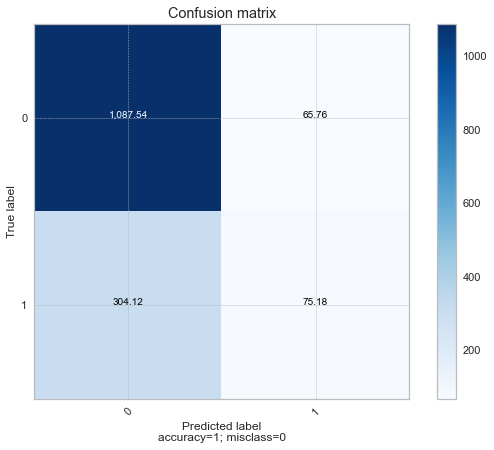

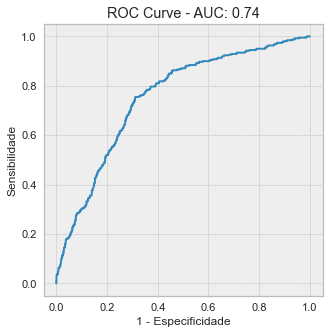

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,LogisticRegression Classifier,6.964303,0.76,0.53,0.2,0.29,0.94,0.78,0.57,0.74,0.18,0.21


In [28]:
lr = LogisticRegression()
lr_result_cv = udf_cross_validation(X_df_train, y_df_train, 'LogisticRegression Classifier', lr, 10, 10, verbose=False)
lr_result_cv

# 10.0 BALANCING DATASET

Dados desbalanceados.

Class distribution
0.0    14381
1.0     4777
Name: target, dtype: int64


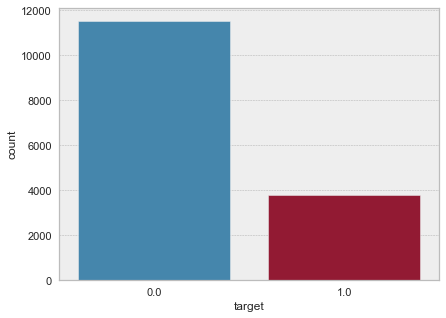

In [29]:
print('Dados desbalanceados.\n')
print('Class distribution\n{}'.format(df3['target'].value_counts()))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='target', data=y_df_train);

Dados Balanceados após aplicação da técnica de Oversampling com a biblioteca SMOTETomek.


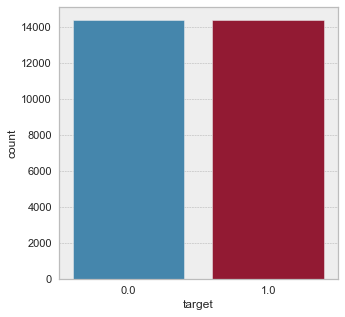

In [30]:
# ratio_balanced = (majority class / minority class) * minority class
balance = int( ( df3['target'].value_counts()[0]/df3['target'].value_counts()[1] ) * df3['target'].value_counts()[1] )
ratio_balanced = {0 : df3['target'].value_counts()[0], 1: balance}

#smt = SMOTE(sampling_strategy='auto')
smt = SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)
X_df_train_resampled, y_df_train_resampled = smt.fit_sample(X_df_train, y_df_train)

#plt.subplot(1,2,2)
print('Dados Balanceados após aplicação da técnica de Oversampling com a biblioteca SMOTETomek.')
sns.countplot(x='target', data=y_df_train_resampled);

# 11.0 MACHINE LEARNING MODELLING

## 11.1 Confuson Matrix

#### True Positive (TP): It refers to the number of predictions where the classifier correctly predicts the positive class as positive.

#### True Negative (TN): It refers to the number of predictions where the classifier correctly predicts the negative class as negative.

#### False Positive (FP): It refers to the number of predictions where the classifier incorrectly predicts the negative class as positive.

#### False Negative (FN): It refers to the number of predictions where the classifier incorrectly predicts the positive class as negative.

![confusion_matrix](img/matriz_confusao2.png)

## 11.2 Metrics

**Accuracy:** It gives you the overall accuracy of the model, meaning the fraction of the total samples that were correctly classified by the classifier. To calculate accuracy, use the following formula: **(TP+TN)/(TP+TN+FP+FN).**

**Misclassification Rate:** It tells you what fraction of predictions were incorrect. It is also known as Classification Error. You can calculate it using **(FP+FN)/(TP+TN+FP+FN) or (1-Accuracy).**

**Precision:** It tells you what fraction of predictions as a positive class were actually positive. To calculate precision, use the following formula: **TP/(TP+FP).**

**Recall:** True positive rate, sensitivity. It tells you what fraction of all positive samples were correctly predicted as positive by the classifier. It is also known as True Positive Rate (TPR), Sensitivity, Probability of Detection. To calculate Recall, use the following formula: **TP/(TP+FN).**]

**Specificity:** It tells you what fraction of all negative samples are correctly predicted as negative by the classifier. It is also known as True Negative Rate (TNR). To calculate specificity, use the following formula: **TN/(TN+FP).**

**F1-score:** It combines precision and recall into a single measure. Mathematically it’s the harmonic mean of precision and recall. It can be calculated as follows:


### Now, in a perfect world, we’d want a model that has a precision of 1 and a recall of 1. That means a F1-score of 1, i.e. a 100% accuracy which is often not the case for a machine learning model. So what we should try, is to get a higher precision with a higher recall value.

## 11.3 Naive Bayes Classifier  

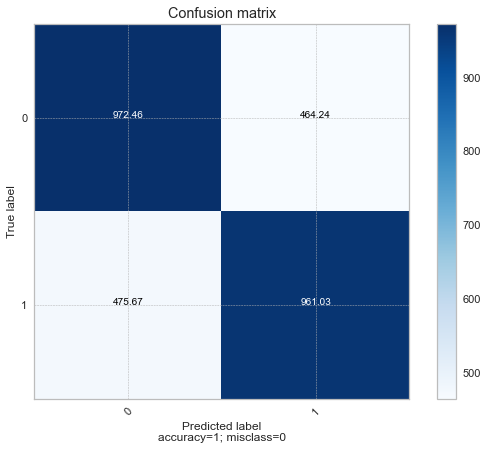

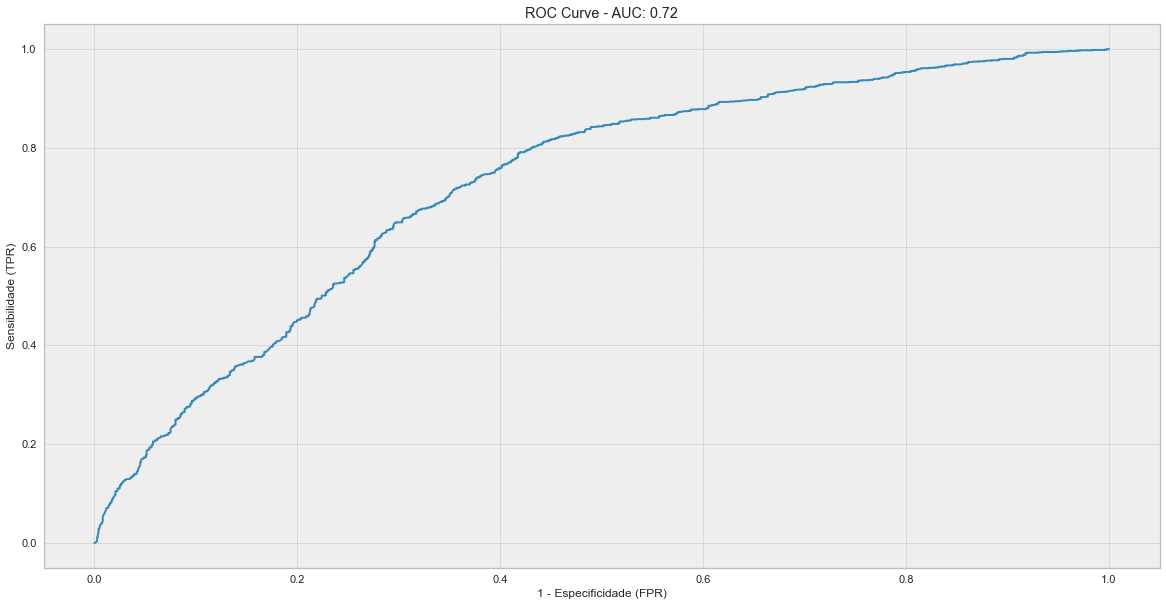

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Naive Bayes Classifier,3.69817,0.67,0.67,0.67,0.67,0.68,0.67,0.67,0.72,0.35,0.35


In [35]:
nb = GaussianNB()
nb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Naive Bayes Classifier', nb, 10, 10, verbose=False)
nb_result_cv

## 11.4 Decision Tree Classifier  

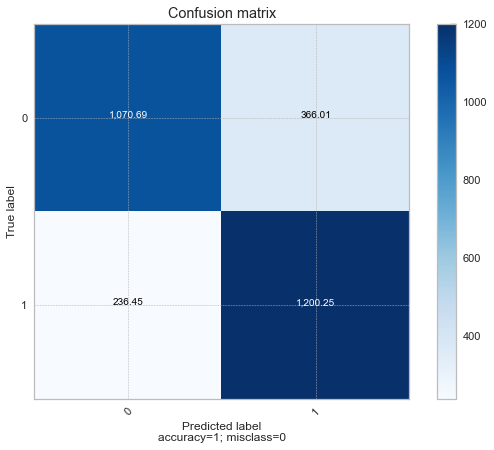

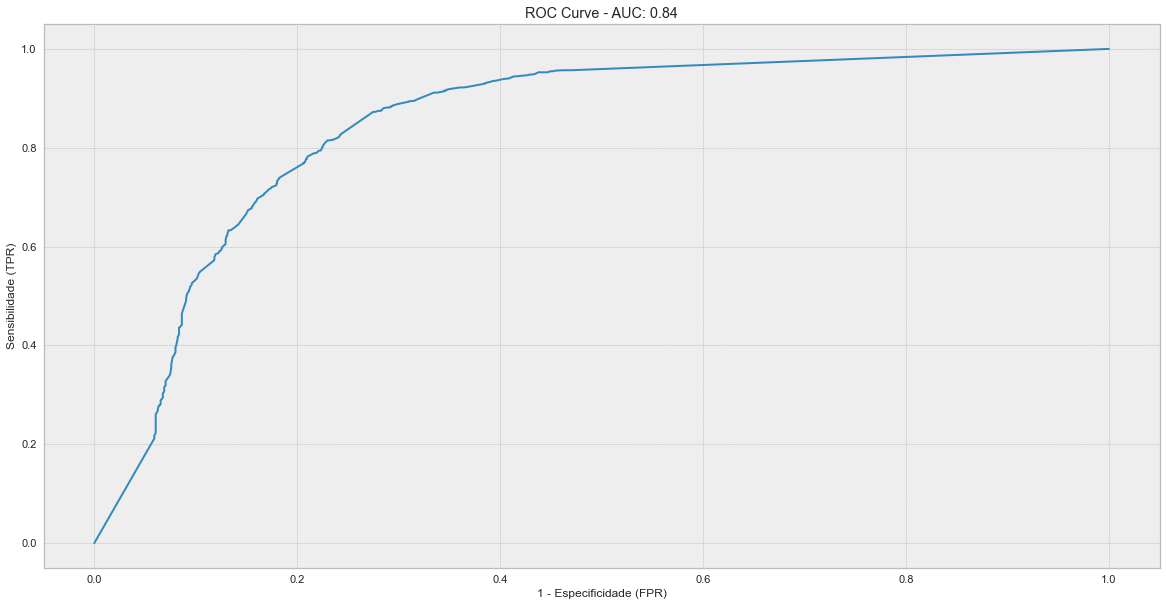

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,DecisionTreeClassifier,6.63681,0.79,0.77,0.84,0.8,0.75,0.82,0.79,0.84,0.58,0.58


In [36]:
dtc = DecisionTreeClassifier()
dtc_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'DecisionTreeClassifier', dtc, 10, 10, verbose=False)
dtc_result_cv

## 11.5 KNN Classifier  

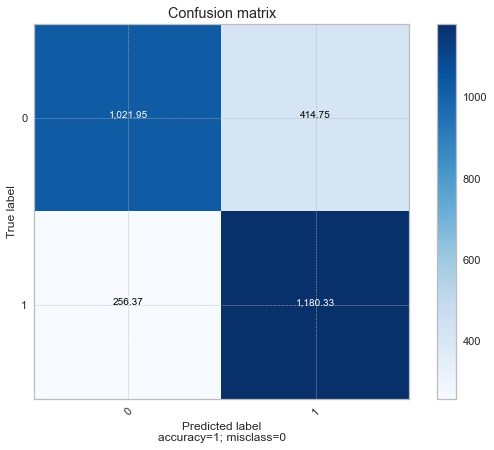

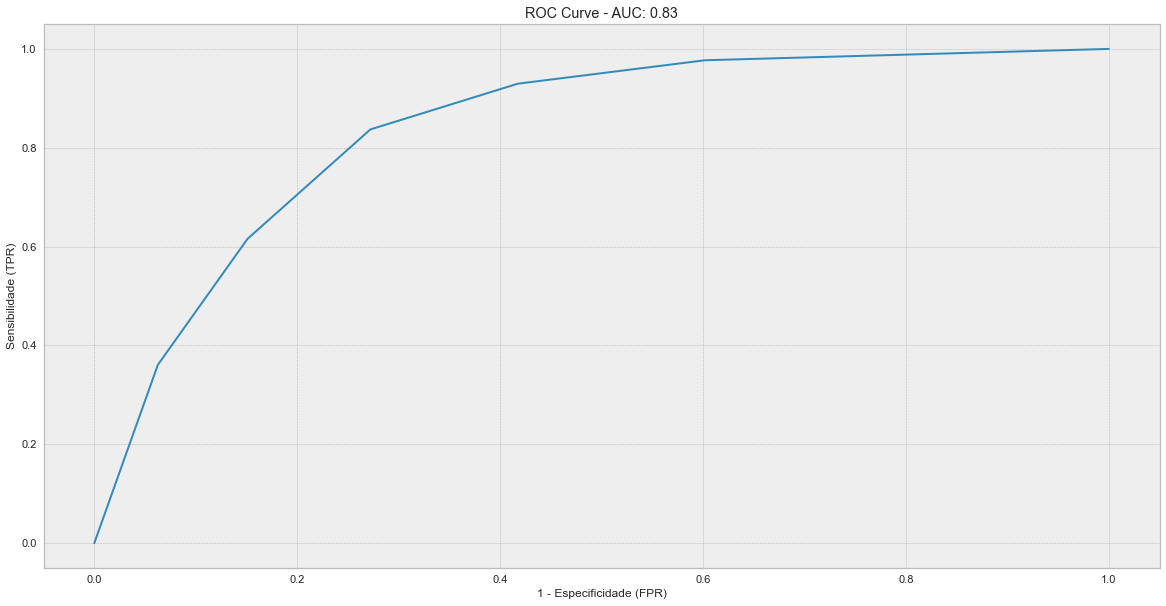

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,KNN Classifier,71.634584,0.77,0.74,0.82,0.78,0.71,0.8,0.77,0.83,0.53,0.54


In [37]:
knn = KNeighborsClassifier()
knn_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'KNN Classifier', knn, 10, 10, verbose=False)
knn_result_cv

## 11.6 LogisticRegression Classifier

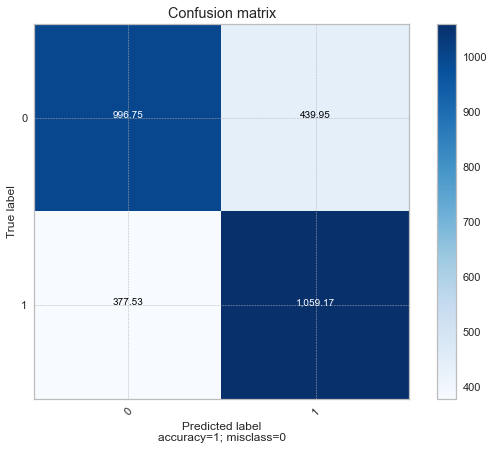

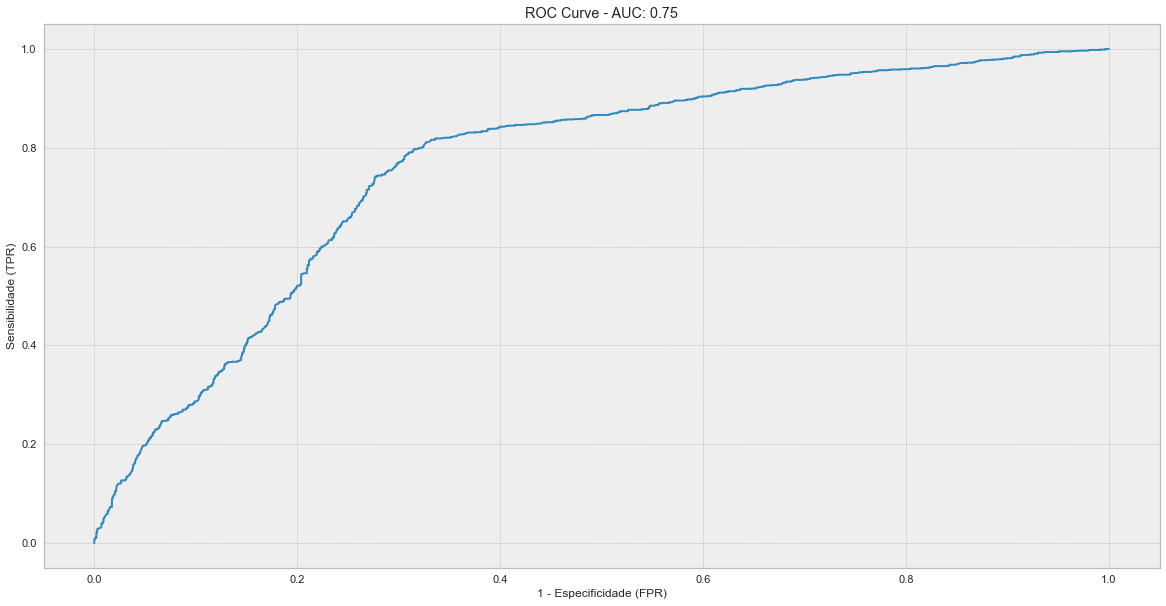

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,LogisticRegression Classifier,15.447053,0.72,0.71,0.74,0.72,0.69,0.73,0.72,0.75,0.43,0.43


In [39]:
lr = LogisticRegression()
lr_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'LogisticRegression Classifier', lr, 10, 10, verbose=False)
lr_result_cv

## 11.7 Support Vector Machine Classifier

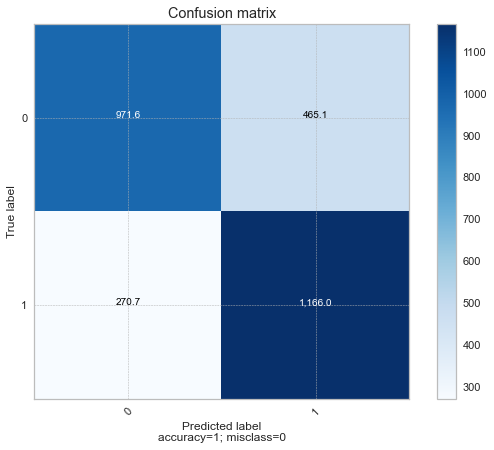

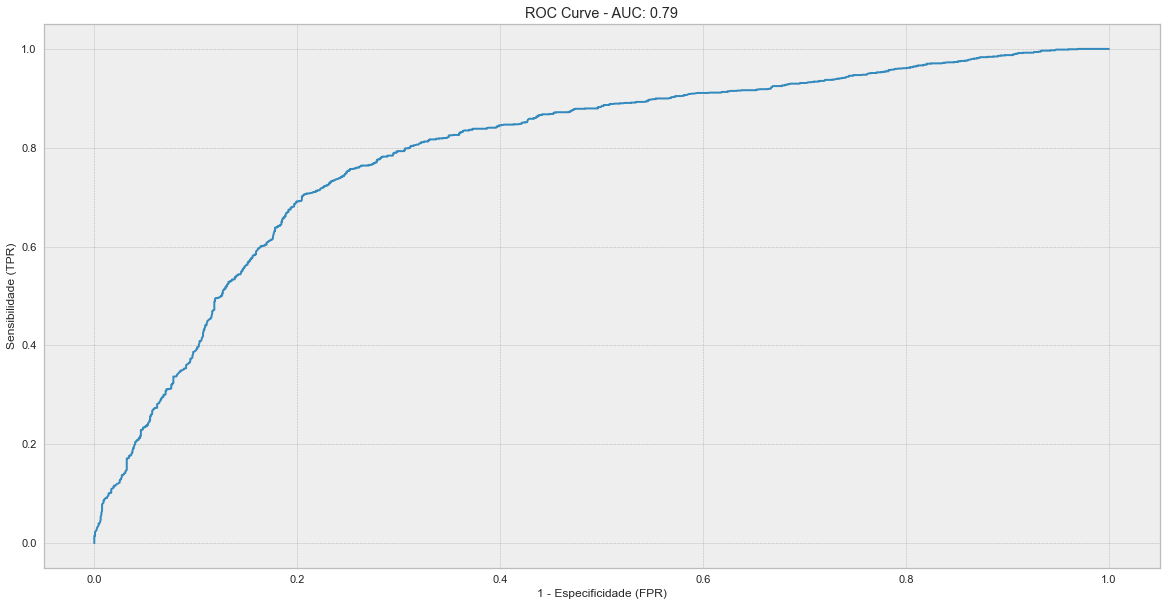

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,SVM Classifier,1146.061857,0.74,0.71,0.81,0.76,0.68,0.78,0.74,0.79,0.49,0.49


In [43]:
svm = SVC( probability=True )
svm_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'SVM Classifier', svm, 10, 1, verbose=False)
svm_result_cv

## 11.8 Neural Network Classifier

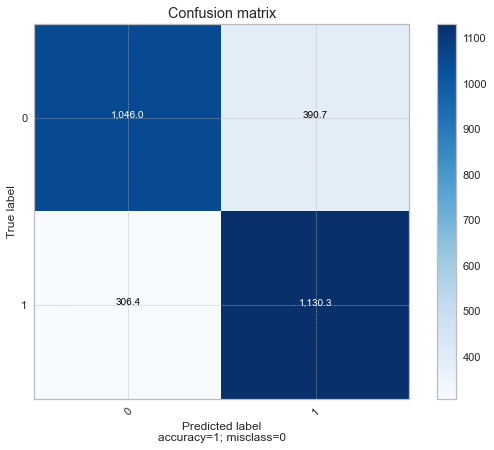

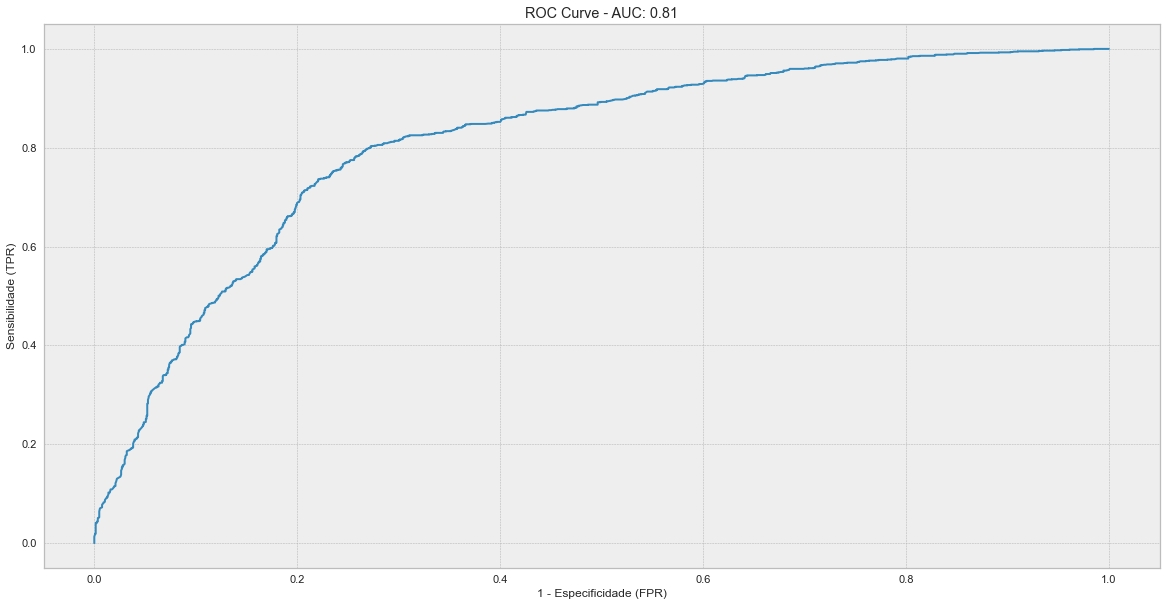

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,NeuralNertwork Classifier,313.586104,0.76,0.74,0.79,0.76,0.73,0.77,0.76,0.81,0.51,0.52


In [42]:
mlp = MLPClassifier(verbose=False)
mlp_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'NeuralNertwork Classifier', mlp, 10, 1, verbose=False)
mlp_result_cv

## 11.9 Random Forest Classifier

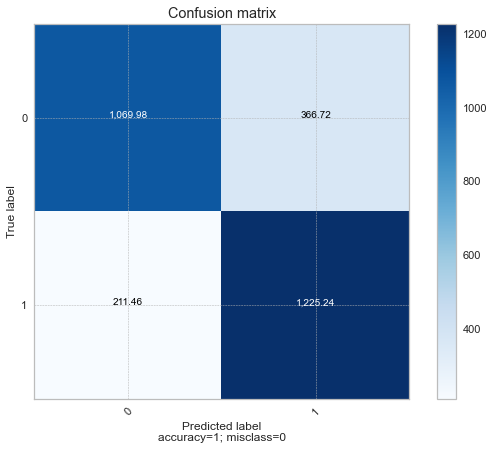

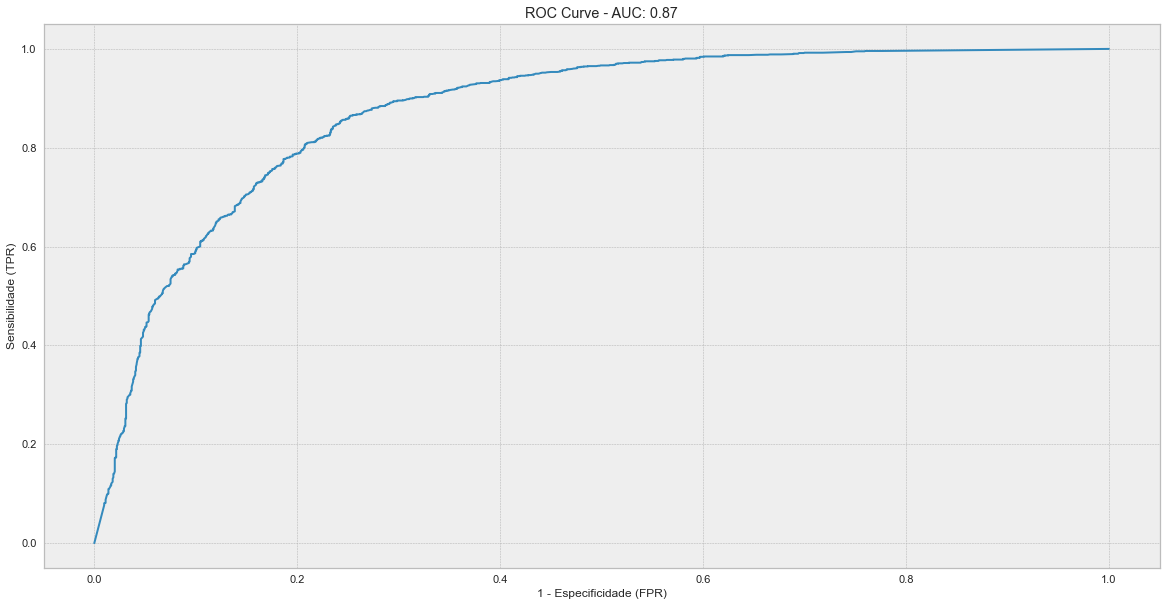

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,Random Forest Classifier,181.349128,0.8,0.77,0.85,0.81,0.74,0.83,0.8,0.87,0.6,0.6


In [38]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'Random Forest Classifier', rf, 10, 10, verbose=False)
rf_result_cv

## 11.10 XGBoost Classifier

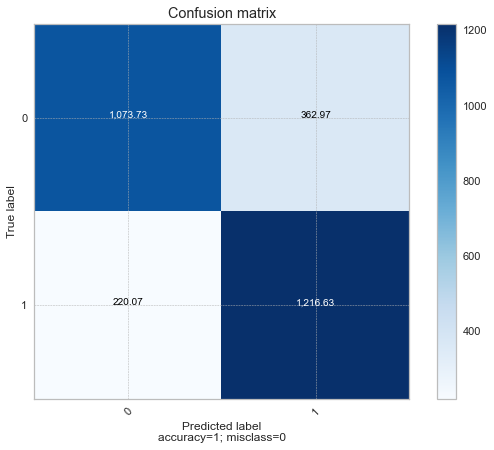

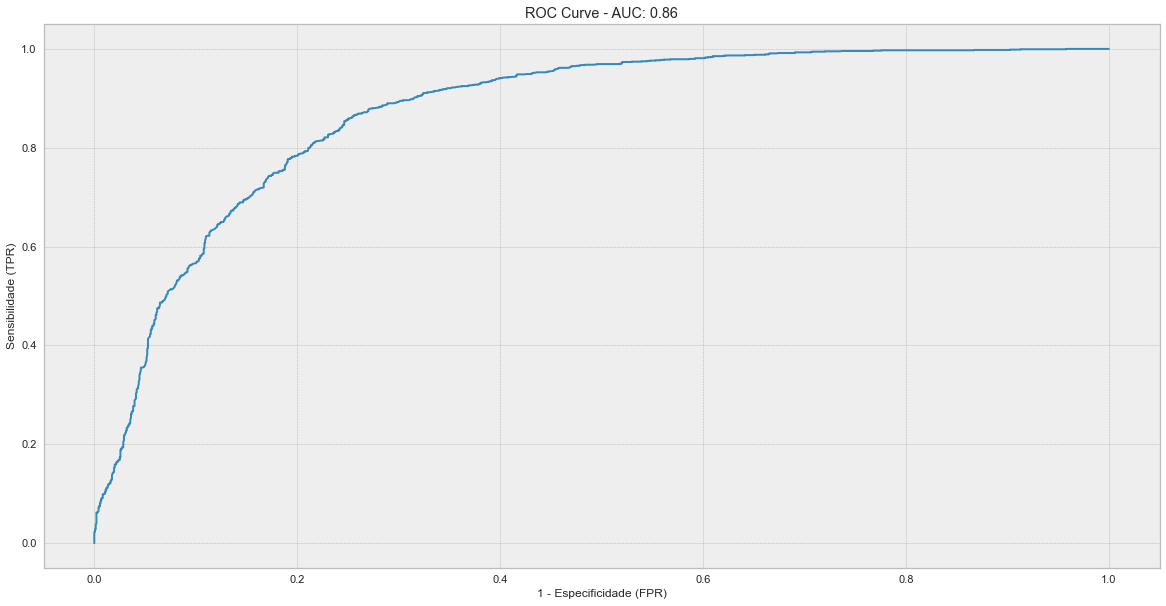

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XGBoost Classifier,658.08435,0.8,0.77,0.85,0.81,0.75,0.83,0.8,0.86,0.59,0.6


In [40]:
xgb_model = XGBClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgb_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoost Classifier', xgb_model, 10, 10, verbose=False)
xgb_result_cv

## 11.11 XGBoostRF Classifier

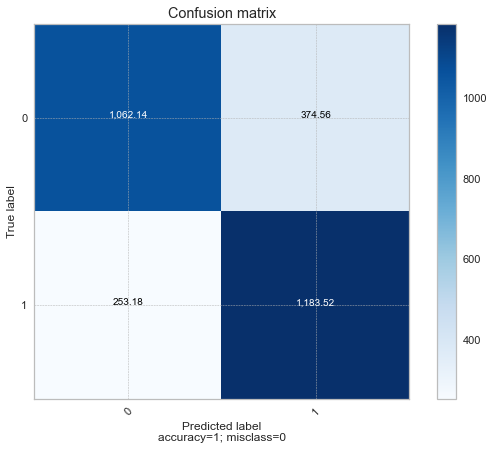

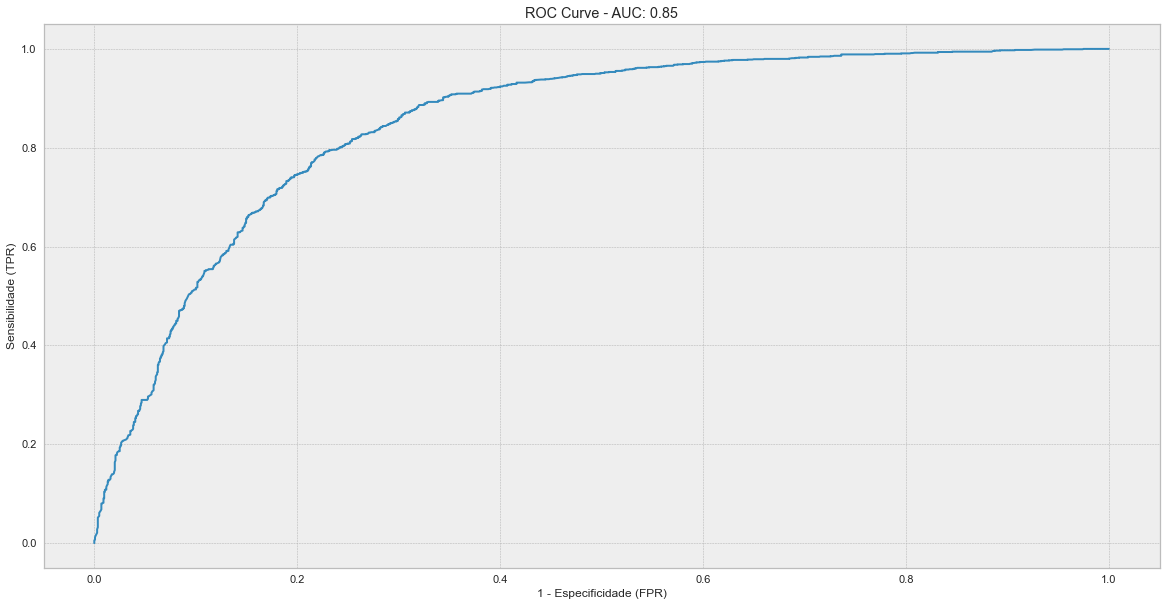

,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
0,XGBoostRF Classifier,261.182797,0.78,0.76,0.82,0.79,0.74,0.81,0.78,0.85,0.56,0.57


In [46]:
xgbrf_model = XGBRFClassifier(n_jobs=-1, subsample=1.0, n_estimators=210, min_samples_split=32, min_samples_leaf=22, max_features=13, max_depth=85, learning_rate=0.11800000000000001)
xgbrf_result_cv = udf_cross_validation(X_df_train_resampled, y_df_train_resampled, 'XGBoostRF Classifier', xgbrf_model, 10, 5, verbose=False)
xgbrf_result_cv

## 11.12 Real Model´s Performance

In [61]:
model_result_cv = pd.concat([nb_result_cv, dtc_result_cv, knn_result_cv, lr_result_cv, svm_result_cv, mlp_result_cv, rf_result_cv, xgb_result_cv, xgbrf_result_cv]).reset_index()
model_result_cv.sort_values(by='Accuracy score',  ascending=False)

,index,Classifier Name,Tempo de execução (s):,Accuracy score,Precision score,Recall score,F1 score,Specificity,NPV,Balanced Accuracy score,AUC,Kappa score,Matthews Correlation Coefficient
6,0,Random Forest Classifier,181.349128,0.8,0.77,0.85,0.81,0.74,0.83,0.8,0.87,0.6,0.6
7,0,XGBoost Classifier,658.084350,0.8,0.77,0.85,0.81,0.75,0.83,0.8,0.86,0.59,0.6
1,0,DecisionTreeClassifier,6.636810,0.79,0.77,0.84,0.8,0.75,0.82,0.79,0.84,0.58,0.58
8,0,XGBoostRF Classifier,261.182797,0.78,0.76,0.82,0.79,0.74,0.81,0.78,0.85,0.56,0.57
2,0,KNN Classifier,71.634584,0.77,0.74,0.82,0.78,0.71,0.8,0.77,0.83,0.53,0.54
5,0,NeuralNertwork Classifier,313.586104,0.76,0.74,0.79,0.76,0.73,0.77,0.76,0.81,0.51,0.52
4,0,SVM Classifier,1146.061857,0.74,0.71,0.81,0.76,0.68,0.78,0.74,0.79,0.49,0.49
3,0,LogisticRegression Classifier,15.447053,0.72,0.71,0.74,0.72,0.69,0.73,0.72,0.75,0.43,0.43
0,0,Naive Bayes Classifier,3.698170,0.67,0.67,0.67,0.67,0.68,0.67,0.67,0.72,0.35,0.35


# 8.0 HYPERPARAMETER FINE TUNNING

## 8.1 Random Search

## 8.2 Baseline Classifier - Majority Learner/ZeroR

In [78]:
# Baseline classifier y_test
counter = collections.Counter(y_test)
base_line= np.array( [ counter[0] / (counter[0] + counter[1]), counter[1] / (counter[0] + counter[1]) ] )
base_line.max()

0.8275

## 8.3 Final Model Training

# 9.0 MODEL TRANSLATION AND INTERPRETATION